There have been many discussions about links between samples in the train and test data, because the robot's absolute orientation does not change much in one run. This means that a) it is dangerously easy to create a model which looks like it predicts surfaces when in fact it predicts orientation and b) we might gain some additional knowledge about the data.

Let's settle this once and for all.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

First, let's get our raw data:

In [2]:
train_X = pd.read_csv('../input/X_train.csv').iloc[:,3:].values.reshape(-1,128,10)
test_X  = pd.read_csv('../input/X_test.csv' ).iloc[:,3:].values.reshape(-1,128,10)
print('train_X shape:', train_X.shape, ', test_X shape:', test_X.shape)

train_X shape: (3810, 128, 10) , test_X shape: (3816, 128, 10)


...and y / group data:

In [3]:
df_train_y = pd.read_csv('../input/y_train.csv')

# build a dict to convert surface names into numbers
surface_names = df_train_y['surface'].unique()
num_surfaces = len(surface_names)
surface_to_numeric = dict(zip(surface_names, range(num_surfaces)))
print('Convert to numbers: ', surface_to_numeric)

# y and group data as numeric values:
train_y = df_train_y['surface'].replace(surface_to_numeric).values
train_group = df_train_y['group_id'].values

Convert to numbers:  {'fine_concrete': 0, 'concrete': 1, 'soft_tiles': 2, 'tiled': 3, 'soft_pvc': 4, 'hard_tiles_large_space': 5, 'carpet': 6, 'hard_tiles': 7, 'wood': 8}


Let's plot the 4 orientation channels of a random group in series:

In [4]:
train_X.shape

(3810, 128, 10)

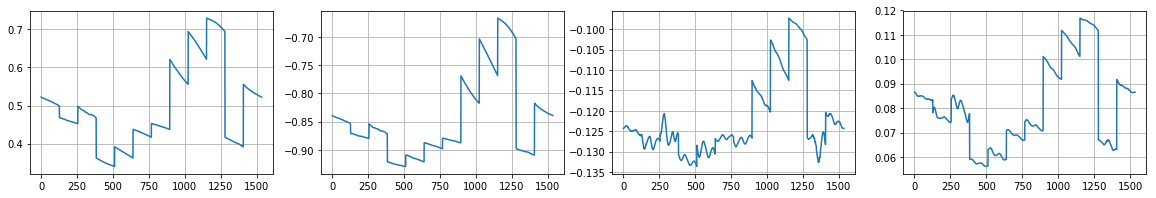

In [5]:
fig, axes = plt.subplots(1,4)
fig.set_size_inches(20,3)

for i in range(4):
    axes[i].plot(train_X[train_group == 17][:,:,i].reshape(-1))
    axes[i].grid(True)

Well, that certainly looks like a jigsaw puzzle to me. And that leads to an idea: the euclidean distance in the 4-dimensional "orientation space" between, for example, the right edge of one sample and the left edge of its true neighbor should be a minimum, *ideally even among all samples*, not only the samples in its group. Same for left/right. This should enable us to stitch the runs together again. All we have to do is link samples together which are *each other's* closest neighbors. Let's code:

In [6]:
def sq_dist(a,b):
    ''' the squared euclidean distance between two samples '''
    
    return np.sum((a-b)**2, axis=1)


def find_run_edges(data, edge):
    ''' examine links between samples. left/right run edges are those samples which do not have a link on that side. '''

    if edge == 'left':
        border1 = 0
        border2 = -1
    elif edge == 'right':
        border1 = -1
        border2 = 0
    else:
        return False
    
    edge_list = []
    linked_list = []
    
    for i in range(len(data)):
        dist_list = sq_dist(data[i, border1, :4], data[:, border2, :4]) # distances to rest of samples
        min_dist = np.min(dist_list)
        closest_i   = np.argmin(dist_list) # this is i's closest neighbor
        if closest_i == i: # this might happen and it's definitely wrong
            print('Sample', i, 'linked with itself. Next closest sample used instead.')
            closest_i = np.argsort(dist_list)[1]
        dist_list = sq_dist(data[closest_i, border2, :4], data[:, border1, :4]) # now find closest_i's closest neighbor
        rev_dist = np.min(dist_list)
        closest_rev = np.argmin(dist_list) # here it is
        if closest_rev == closest_i: # again a check
            print('Sample', i, '(back-)linked with itself. Next closest sample used instead.')
            closest_rev = np.argsort(dist_list)[1]
        if (i != closest_rev): # we found an edge
            edge_list.append(i)
        else:
            linked_list.append([i, closest_i, min_dist])
            
    return edge_list, linked_list


def find_runs(data, left_edges, right_edges):
    ''' go through the list of samples & link the closest neighbors into a single run '''
    
    data_runs = []

    for start_point in left_edges:
        i = start_point
        run_list = [i]
        while i not in right_edges:
            tmp = np.argmin(sq_dist(data[i, -1, :4], data[:, 0, :4]))
            if tmp == i: # self-linked sample
                tmp = np.argsort(sq_dist(data[i, -1, :4], data[:, 0, :4]))[1]
            i = tmp
            run_list.append(i)
        data_runs.append(np.array(run_list))
    
    return data_runs

Let's go:

In [9]:
train_left_edges, train_left_linked  = find_run_edges(train_X, edge='left')
train_right_edges, train_right_linked = find_run_edges(train_X, edge='right')
print('Found', len(train_left_edges), 'left edges and', len(train_right_edges), 'right edges.')

Sample 1 (back-)linked with itself. Next closest sample used instead.
Sample 216 linked with itself. Next closest sample used instead.
Sample 335 linked with itself. Next closest sample used instead.
Sample 748 (back-)linked with itself. Next closest sample used instead.
Sample 799 linked with itself. Next closest sample used instead.
Sample 1205 linked with itself. Next closest sample used instead.
Sample 1913 linked with itself. Next closest sample used instead.
Sample 1986 linked with itself. Next closest sample used instead.
Sample 2555 linked with itself. Next closest sample used instead.
Sample 2612 linked with itself. Next closest sample used instead.
Sample 2761 linked with itself. Next closest sample used instead.
Sample 2917 linked with itself. Next closest sample used instead.
Sample 3312 linked with itself. Next closest sample used instead.
Sample 181 linked with itself. Next closest sample used instead.
Sample 272 linked with itself. Next closest sample used instead.
Sampl

Well, that certainly looks promising. Found 76 runs, similar number than the number of groups. Build the runs:

In [10]:
train_runs = find_runs(train_X, train_left_edges, train_right_edges)

In [11]:
len(train_runs)

76

Have we found all samples? Have we used any sample twice? The answer is yes, and no. Perfect.

In [12]:
train_runs

[array([  19,  757, 1680,  452,  504, 1643,   88, 1084, 1474,  759,  137,
         372,  989,  150, 1022,  253, 1378,   80,  997,   30,  849,  577,
        1015,  445,  370,   24,   52, 1357,  644, 1624, 1182, 1128, 1497,
         888,  293, 1582,  440, 1551,  468,  733, 1503, 1487,  627,   31,
        1622,  321,  541,  485,  135,  129, 1601, 1172,  976,  637,  406,
         832,  943, 1396,  740, 1028, 1627,  114,  568,  760, 1362,  298,
        1327, 1146, 1682, 1530,  597, 1337, 1549,  307, 1342, 1491,  508,
         348,  136,  763,  291, 1676,  910,  106,  240, 1147,  480, 1268,
         776, 1375,  731,  650,  140, 1120,  773, 1675,  258, 1677, 1517,
        1314,  844]),
 array([  74,  515,  965, 1382,  391,  929,  341,  418,   39,  369, 1195,
         138, 1573, 1189,  217, 1305, 1228,  783, 1398,  483, 1278, 1027,
          89, 1273, 1499,  898,  975,  754, 1043,  829, 1107,  322,  297,
         442, 1606, 1469,  110, 1674, 1122, 1464, 1440,  522,   43,  732,
         622, 16

In [13]:
flat_list = [series_id for run in train_runs for series_id in run]
print(len(flat_list), len(np.unique(flat_list)))

3810 3810


Now for the real test. How many different surfaces are in each run? *Only 4 runs have more than one surface* (and if you look at them, you can easily split them by hand). This actually works!

In [14]:
print([ len(np.unique(train_y[run])) for run in train_runs ])

[1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1]


Interesting. Some runs contain  2, 3 and even 4 groups. So several groups were cut from one run:

In [15]:
print([ len(np.unique(train_group[run])) for run in train_runs ])

[2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 4, 1, 1, 2, 1, 1, 2, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1]


Let's plot all 10 channels for one run.  Beautiful.

In [16]:
np.where(np.asarray([len(np.unique(train_y[run])) for run in train_runs ])==2)

(array([ 7, 52, 59, 71]),)

In [17]:
np.where(np.asarray([len(np.unique(train_group[run])) for run in train_runs])>1)

(array([ 0,  1,  2,  7, 18, 21, 23, 25, 26, 28, 30, 31, 40, 41, 44, 45, 49,
        52, 54, 56, 59, 62, 65, 69, 71]),)

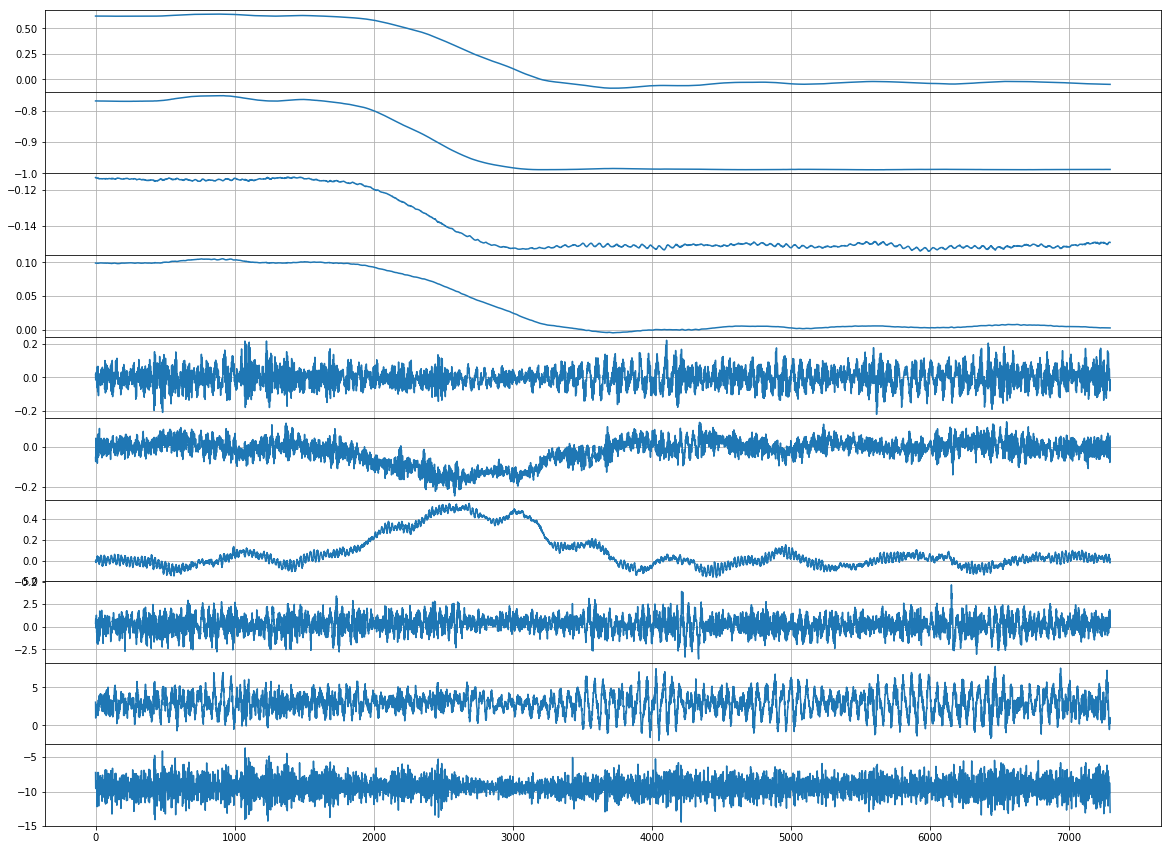

In [18]:
fig, axes = plt.subplots(10,1, sharex=True)
fig.set_size_inches(20,15)
fig.subplots_adjust(hspace=0)

for i in range(10):
    axes[i].plot(train_X[train_runs[10]][:,:,i].reshape(-1))
    axes[i].grid(True)

Let's add our new knowledge to train_y. Now you can use this info to train your models to even greater perfection. Enjoy!

...But wait. Might this also work with the test data?

In [19]:
test_left_edges, test_left_linked  = find_run_edges(test_X, edge='left')
test_right_edges, test_right_linked = find_run_edges(test_X, edge='right')
print('Found', len(test_left_edges), 'left edges and', len(test_right_edges), 'right edges.')

Sample 355 linked with itself. Next closest sample used instead.
Sample 580 linked with itself. Next closest sample used instead.
Sample 1402 linked with itself. Next closest sample used instead.
Sample 1547 linked with itself. Next closest sample used instead.
Sample 1716 linked with itself. Next closest sample used instead.
Sample 2136 (back-)linked with itself. Next closest sample used instead.
Sample 2474 linked with itself. Next closest sample used instead.
Sample 2495 (back-)linked with itself. Next closest sample used instead.
Sample 2600 linked with itself. Next closest sample used instead.
Sample 2922 linked with itself. Next closest sample used instead.
Sample 580 linked with itself. Next closest sample used instead.
Sample 1216 linked with itself. Next closest sample used instead.
Sample 1409 linked with itself. Next closest sample used instead.
Sample 1410 linked with itself. Next closest sample used instead.
Sample 1670 linked with itself. Next closest sample used instead.

Oh yeah!

In [20]:
test_runs = find_runs(test_X, test_left_edges, test_right_edges)

Again no samples are used twice, but we have lost some.

In [21]:
flat_list = [series_id for run in test_runs for series_id in run]
print(len(flat_list), len(np.unique(flat_list)))

3790 3790


 3816 - 3790 = 26 samples are not in any run and aren't edges. They must form a closed ring -> another run. find it:

In [22]:
lost_samples = np.array([ i for i in range(len(test_X)) if i not in np.concatenate(test_runs) ])
print(lost_samples)
print(len(lost_samples))

[ 264  361  529  620  733  954 1148 1248 1432 1534 1570 1738 1739 2090
 2205 2714 2847 2978 2991 3115 3173 3183 3195 3359 3517 3655]
26


In [24]:
find_run_edges(test_X[lost_samples], edge='left')[1][0]

[0, 5, 2.0548399999999954e-07]

In [23]:
lost_run = np.array(lost_samples[find_runs(test_X[lost_samples], [0], [5])[0]])
test_runs.append(lost_run)

Perfect. Now we also have test runs. A nice plot to prove it:

In [24]:
test_runs[61]

array([3050, 1566,  317,  692, 1535,  215, 2879, 3416, 3739, 2328, 1218,
       3665, 2624,  488, 2773,  423,  359,   20, 2339, 1154, 1089, 1013,
        871, 1019, 1074, 2552, 3805,  972, 1115,  850,  479,  631,  592,
       2104, 1303, 1882, 1907,  230, 3751, 2569,  214,  484, 3000, 1103,
       1528,  686, 3698, 1273,  414, 2361, 3346, 2526, 3155,  199, 3028,
       3154, 1530, 1041,  224, 2525, 1258, 3361, 3048, 2317, 1311,   21,
       3085, 2220, 1000,  342, 1985, 1341, 2970, 3010, 2013,  277, 2284,
       3036, 2816, 3087, 2296,   28, 2992, 3142, 2426, 2779,  857, 3399,
        896,  196, 2055, 2089, 1831, 2388, 3248,  538, 1263, 3149, 3069,
       3543, 3108, 2633, 3521, 2238, 3252,  673, 1743, 2546, 2134, 3758,
       1372, 1496, 3556,  490, 1508, 2353,  697,  834, 1467, 3254, 1226,
        981, 3180, 1143, 1602, 1274, 2496, 1849,  351, 1919,  880, 3339,
       3757, 2390, 1420, 2852, 3396, 2657, 2065,  547, 2394, 3616, 1225,
       3697, 3607, 2894, 1235, 1112, 3754,  713, 30

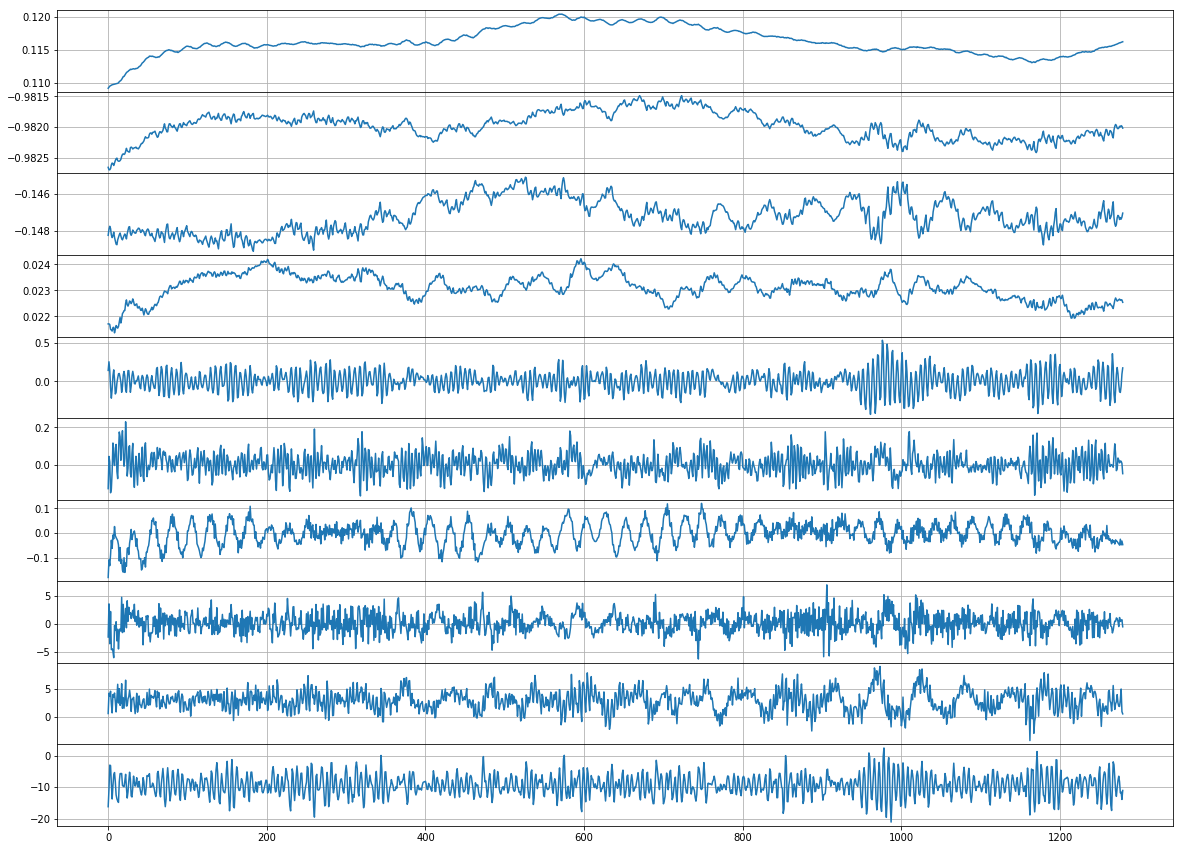

In [27]:
fig, axes = plt.subplots(10,1, sharex=True)
fig.set_size_inches(20,15)
fig.subplots_adjust(hspace=0)

for i in range(10):
    axes[i].plot(test_X[test_runs[61][-10:]][:,:,i].reshape(-1))
    axes[i].grid(True)

I'll leave you with a caution and an exercise:
First, there are certainly some errors in the test runs. Two runs with different surfaces might have been stitched into one (as happened 4 times with the train data) by chance.
Second, might it even be possible to link *across train and test*? Well, see for yourself...

In [25]:
train_runs.append(train_runs[7][43:])
train_runs[7] = train_runs[7][:43]
train_runs.append(train_runs[52][9:])
train_runs[52] = train_runs[52][:9]
train_runs.append(train_runs[59][80:])
train_runs[59] = train_runs[59][:80]
train_runs.append(train_runs[71][6:])
train_runs[71] = train_runs[71][:6]

In [26]:
test_runs.append(test_runs[61][-10:])
test_runs[61] = test_runs[61][:-10]

In [27]:
train_runs

[array([  19,  757, 1680,  452,  504, 1643,   88, 1084, 1474,  759,  137,
         372,  989,  150, 1022,  253, 1378,   80,  997,   30,  849,  577,
        1015,  445,  370,   24,   52, 1357,  644, 1624, 1182, 1128, 1497,
         888,  293, 1582,  440, 1551,  468,  733, 1503, 1487,  627,   31,
        1622,  321,  541,  485,  135,  129, 1601, 1172,  976,  637,  406,
         832,  943, 1396,  740, 1028, 1627,  114,  568,  760, 1362,  298,
        1327, 1146, 1682, 1530,  597, 1337, 1549,  307, 1342, 1491,  508,
         348,  136,  763,  291, 1676,  910,  106,  240, 1147,  480, 1268,
         776, 1375,  731,  650,  140, 1120,  773, 1675,  258, 1677, 1517,
        1314,  844]),
 array([  74,  515,  965, 1382,  391,  929,  341,  418,   39,  369, 1195,
         138, 1573, 1189,  217, 1305, 1228,  783, 1398,  483, 1278, 1027,
          89, 1273, 1499,  898,  975,  754, 1043,  829, 1107,  322,  297,
         442, 1606, 1469,  110, 1674, 1122, 1464, 1440,  522,   43,  732,
         622, 16

In [28]:
test_runs

[array([  45,  619,  814, 1598, 1945,  480,  695, 1279,  621, 1648,   51,
        2170, 2096, 2642, 2160, 2064, 3771, 1111,  884,  390, 2462, 1616,
         628, 2561, 3013, 2149, 2082,  202,  696, 2154, 2358,  816,  883,
        3038, 3238, 3642, 1484, 2676, 3516, 1917, 1404, 2975, 2964, 1636,
        1560, 2647, 1970, 3208, 1568,  646, 2054, 1952, 1630,  273, 1723,
        3269,  357, 3652,  434, 1688, 2897, 1299, 2435, 3112, 3571,  343,
        1615, 2813, 2354, 1828,  216,  521, 2381,  817, 1331, 3166, 1822,
         271, 2520, 1358,  551, 1631, 1147, 3023, 3704, 3218, 3755,  405,
         469,  293, 1575, 2458,  387, 2585,   13, 1415, 2374, 1323,  197,
         826,  828, 3503, 2027, 2953, 1944, 2099, 2658, 1361, 1021, 3620,
        2942, 1070, 2763,  616,  712, 1405, 1781, 1628, 1709, 3089,  722,
        1926, 3398, 2219, 2983, 1371, 3633, 1281, 3237,  565, 1612, 2973,
         985, 3747,  790, 2643, 3591, 3358,  167, 1362, 1176, 3500,  639,
         483, 3595, 3042, 2812, 1184, 

In [29]:
def find_run_edges_2(train, test, edge, train_runs, test_runs):
    ''' examine links between samples. left/right run edges are those samples which do not have a link on that side. '''

    if edge == 'left':
        border1 = 0
        border2 = -1
    elif edge == 'right':
        border1 = -1
        border2 = 0
    else:
        return False
    
    edge_list = []
    linked_list = []
    
    test_first = []
    test_last = []
    for te_num in range(len(test_runs)):
        test_first.append(test_runs[te_num][0])
        test_last.append(test_runs[te_num][-1])
    
    train_first = []
    train_last = []
    for tr_num in range(len(train_runs)):
        train_first.append(train_runs[tr_num][0])
        train_last.append(train_runs[tr_num][-1])
        
    if edge == 'left':
        for i in range(len(test_runs)):
            dist_list = sq_dist(test[test_runs[i][0], border1, :4], train[train_last, border2, :4]) # distances to rest of samples
            min_dist = np.min(dist_list)
            closest_i   = np.argmin(dist_list) # this is i's closest neighbor
            #if closest_i == i: # this might happen and it's definitely wrong
            #    print('Sample', i, 'linked with itself. Next closest sample used instead.')
            #    closest_i = np.argsort(dist_list)[1]
            dist_list = sq_dist(train[train_runs[closest_i][-1], border2, :4], test[test_first, border1, :4]) # now find closest_i's closest neighbor
            rev_dist = np.min(dist_list)
            closest_rev = np.argmin(dist_list) # here it is
            #if closest_rev == closest_i: # again a check
            #    print('Sample', i, '(back-)linked with itself. Next closest sample used instead.')
            #    closest_rev = np.argsort(dist_list)[1]
            if (i != closest_rev): # we found an edge
                edge_list.append(i)
            else:
                linked_list.append([i, closest_i, min_dist])
                
    elif edge == 'right':
        for i in range(len(test_runs)):
            dist_list = sq_dist(test[test_runs[i][0], border1, :4], train[train_first, border2, :4]) # distances to rest of samples
            min_dist = np.min(dist_list)
            closest_i   = np.argmin(dist_list) # this is i's closest neighbor
            #if closest_i == i: # this might happen and it's definitely wrong
            #    print('Sample', i, 'linked with itself. Next closest sample used instead.')
            #    closest_i = np.argsort(dist_list)[1]
            dist_list = sq_dist(train[train_runs[closest_i][-1], border2, :4], test[test_last, border1, :4]) # now find closest_i's closest neighbor
            rev_dist = np.min(dist_list)
            closest_rev = np.argmin(dist_list) # here it is
            #if closest_rev == closest_i: # again a check
            #    print('Sample', i, '(back-)linked with itself. Next closest sample used instead.')
            #    closest_rev = np.argsort(dist_list)[1]
            if (i != closest_rev): # we found an edge
                edge_list.append(i)
            else:
                linked_list.append([i, closest_i, min_dist])
            
    return edge_list, linked_list

In [87]:
def find_runs_2(train, test, left_edges, right_edges, train_runs):
    ''' go through the list of samples & link the closest neighbors into a single run '''
    
    test_first = []
    test_last = []
    for te_num in range(len(test_runs)):
        test_first.append(test_runs[te_num][0])
        test_last.append(test_runs[te_num][-1])
    
    data_runs = []

    for start_point in left_edges:
        i = start_point
        run_list = [i]
        while i not in right_edges:
            dist_list = sq_dist(train[train_runs[i][0], -1, :4], test[test_first, 0, :4])
            #tmp = np.argmin(sq_dist(data[i, -1, :4], data[:, 0, :4]))
            tmp = np.argmin(dist_list)
            #if tmp == i: # self-linked sample
            #    tmp = np.argsort(sq_dist(data[i, -1, :4], data[:, 0, :4]))[1]
            i = tmp
            run_list.append(i)
        data_runs.append(np.array(run_list))
    
    return data_runs

In [30]:
left_edges, left_linked = find_run_edges_2(train_X, test_X, 'left', train_runs, test_runs)

In [31]:
right_edges, right_linked = find_run_edges_2(train_X, test_X, 'right', train_runs, test_runs)

In [88]:
find_runs_2(train_X, test_X, left_edges, right_edges, train_runs)

[array([0]),
 array([1]),
 array([3]),
 array([5]),
 array([11]),
 array([15]),
 array([22]),
 array([23]),
 array([26]),
 array([32]),
 array([37]),
 array([41]),
 array([42]),
 array([43]),
 array([44]),
 array([50]),
 array([51]),
 array([53,  3]),
 array([55]),
 array([56]),
 array([57]),
 array([58, 60]),
 array([59]),
 array([61]),
 array([64]),
 array([65]),
 array([66]),
 array([68]),
 array([69]),
 array([70]),
 array([75]),
 array([76]),
 array([77]),
 array([78]),
 array([79])]

In [32]:
left_edges

[0,
 2,
 5,
 6,
 7,
 8,
 11,
 13,
 18,
 20,
 22,
 23,
 24,
 27,
 33,
 37,
 38,
 39,
 40,
 41,
 42,
 44,
 46,
 50,
 52,
 54,
 55,
 56,
 62,
 63,
 66,
 67,
 72,
 73,
 75,
 76]

In [33]:
right_edges

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76]

In [36]:
len(right_linked)

3

In [37]:
len(left_linked)

41

In [33]:
train_X.shape

(3810, 128, 10)

In [36]:
border1 = 0
border2 = -1

(3810,)

In [53]:
test_first = []
test_last = []
for te_num in range(len(test_runs)):
    test_first.append(test_runs[te_num][0])
    test_last.append(test_runs[te_num][-1])

In [63]:
train_first = []
train_last = []
for tr_num in range(len(train_runs)):
    train_first.append(train_runs[tr_num][0])
    train_last.append(train_runs[tr_num][-1])

In [60]:
np.min(sq_dist(train_X[train_runs[0][0], border1, :4], test_X[test_last, border2, :4]))

0.007860441360999997

In [61]:
dist_list = sq_dist(train_X[train_runs[0][0], border1, :4], test_X[test_last, border2, :4])

In [64]:
closest_i = np.argmin(dist_list)

In [67]:
np.min(sq_dist(test_X[test_runs[closest_i][-1], border2, :4], train_X[train_first, border1, :4]))

3.736099999999474e-08

In [68]:
np.argmin(sq_dist(test_X[test_runs[closest_i][-1], border2, :4], train_X[train_first, border1, :4]))

60

In [69]:
len(dist_list)

77

In [70]:
test_runs[closest_i][-1]

2557

In [71]:
test_last[9]

2557

In [50]:
test_X[test_runs[0][-1], border2, :4]

array([ 0.41592, -0.89726, -0.13123,  0.06869])

In [51]:
train_X[train_runs[0][0], border1, :4]

array([ 0.82149 , -0.55018 , -0.078026,  0.1279  ])

In [58]:
test_X[test_last, border2, :4]

(77, 4)

In [101]:
df_train_y['run_id'] = 0
df_train_y['run_pos'] = 0

for run_id in range(len(train_runs)):
    for run_pos in range(len(train_runs[run_id])):
        series_id = train_runs[run_id][run_pos]
        df_train_y.at[ series_id, 'run_id'  ] = run_id
        df_train_y.at[ series_id, 'run_pos' ] = run_pos

df_train_y.to_csv('y_train_with_runs.csv', index=False)
df_train_y.head()

,series_id,group_id,surface,run_id,run_pos
0,0,13,fine_concrete,21,28
1,1,31,concrete,32,14
2,2,20,concrete,5,4
3,3,31,concrete,32,42
4,4,22,soft_tiles,12,24


In [40]:
df_train_y = df_train_y.sort_values(['run_id', 'run_pos'])

In [102]:
df_test_y  = pd.read_csv('../input/sample_submission.csv')

In [103]:
df_test_y['run_id'] = 0
df_test_y['run_pos'] = 0

for run_id in range(len(test_runs)):
    for run_pos in range(len(test_runs[run_id])):
        series_id = test_runs[run_id][run_pos]
        df_test_y.at[ series_id, 'run_id'  ] = run_id
        df_test_y.at[ series_id, 'run_pos' ] = run_pos

df_test_y.to_csv('y_test_with_runs.csv', index=False)
df_test_y.head()

,series_id,surface,run_id,run_pos
0,0,concrete,14,19
1,1,concrete,57,8
2,2,concrete,42,13
3,3,concrete,65,11
4,4,concrete,68,3


In [105]:
right_linked

[[2, 4, 0.0024473906690000106],
 [9, 14, 6.732598133000003e-05],
 [27, 30, 0.0007502657609999981],
 [36, 13, 0.0007523965959999998],
 [53, 3, 0.003068692029000002],
 [58, 60, 0.0013398949689999993]]

In [115]:
for i in range(len(right_linked)):
    df_test_y.loc[df_test_y['run_id']==right_linked[i][1], 'surface'] = df_train_y.loc[df_train_y['run_id']==right_linked[i][0], 'surface'].iloc[0]

In [117]:
for i in range(len(left_linked)):
    df_test_y.loc[df_test_y['run_id']==left_linked[i][1], 'surface'] = df_train_y.loc[df_train_y['run_id']==left_linked[i][0], 'surface'].iloc[0]

In [32]:
df_test_y = df_test_y.sort_values(['run_id', 'run_pos'])

In [113]:
df_test_y.loc[df_test_y['run_id']==right_linked[0][1], 'surface']

16           NaN
135          NaN
141          NaN
157     concrete
198     concrete
248          NaN
272          NaN
489          NaN
493          NaN
534          NaN
552          NaN
617     concrete
634          NaN
701          NaN
778          NaN
825          NaN
827          NaN
865          NaN
866          NaN
935          NaN
966          NaN
1037         NaN
1150         NaN
1302         NaN
1360         NaN
1364         NaN
1401         NaN
1429         NaN
1586         NaN
1755         NaN
1777         NaN
1778         NaN
2034         NaN
2043         NaN
2167         NaN
2192         NaN
2204         NaN
2466         NaN
2608         NaN
2661         NaN
2688         NaN
2690         NaN
2691         NaN
2817         NaN
2873         NaN
2877         NaN
2882         NaN
2925         NaN
2956         NaN
3014         NaN
3016         NaN
3107         NaN
3189         NaN
3363         NaN
3710         NaN
3718         NaN
Name: surface, dtype: object

In [114]:
df_train_y.loc[df_train_y['run_id']==right_linked[0][0], 'surface'].iloc[0]

'concrete'

In [119]:
submission = df_test_y.iloc[:, :2]
submission.to_csv('../output/submission_12.csv', index=False)
submission.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,concrete
3,3,carpet
4,4,soft_tiles


In [118]:
df_test_y

,series_id,surface,run_id,run_pos
0,0,hard_tiles_large_space,14,19
1,1,concrete,57,8
2,2,concrete,42,13
3,3,carpet,65,11
4,4,soft_tiles,68,3
5,5,concrete,60,17
6,6,soft_pvc,29,13
7,7,concrete,34,31
8,8,concrete,1,6
9,9,concrete,61,164


In [74]:
X_train = pd.read_csv('../input/X_train.csv')
y_train = pd.read_csv('../input/y_train.csv')
X_test  = pd.read_csv('../input/X_test.csv')

In [75]:
X_train = df_train_y.loc[:, ['series_id','run_id', 'run_pos']].merge(X_train, how='left', on='series_id')
X_test = df_test_y.loc[:, ['series_id','run_id', 'run_pos']].merge(X_test, how='left', on='series_id')

In [76]:
X_train = X_train.sort_values(['run_id', 'run_pos'])
X_test = X_test.sort_values(['run_id', 'run_pos'])

In [77]:
X_train.head()

,series_id,run_id,run_pos,row_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
2432,19,0,0,19_0,0,0.82149,-0.55018,-0.078026,0.12790,-0.037375,0.061497,-0.13716,0.024075,3.8925,-9.0722
2433,19,0,0,19_1,1,0.82160,-0.55002,-0.078009,0.12793,-0.014339,0.049700,-0.14883,0.244750,3.8680,-9.2391
2434,19,0,0,19_2,2,0.82170,-0.54987,-0.077994,0.12794,0.002952,0.034608,-0.14425,0.202730,3.9080,-9.0733
2435,19,0,0,19_3,3,0.82181,-0.54968,-0.078020,0.12800,-0.005160,0.040884,-0.15265,-0.056117,4.0634,-8.8846
2436,19,0,0,19_4,4,0.82192,-0.54951,-0.078001,0.12804,-0.017418,0.054860,-0.15416,0.281510,4.0076,-9.1801


In [53]:
def feat_eng(df):
    data = pd.DataFrame()

    df['total_acce'] = (df['linear_acceleration_X']**2 + df['linear_acceleration_Y']**2 + df['linear_acceleration_Z']**2)**0.5
    df['fft_angvel_X'] = np.fft.fft(df['angular_velocity_X']).real
    df['fft_angvel_Y'] = np.fft.fft(df['angular_velocity_Y']).real
    df['fft_angvel_Z'] = np.fft.fft(df['angular_velocity_Z']).real
    df['fft_linacc_X'] = np.fft.fft(df['linear_acceleration_X']).real
    df['fft_linacc_Y'] = np.fft.fft(df['linear_acceleration_Y']).real
    df['fft_linacc_Z'] = np.fft.fft(df['linear_acceleration_Z']).real
    
    
    df_columns = [#'orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W',
                  'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z',
                  'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z',
                  'total_acce']
    name = 'run'
    
    for col in tqdm(df.columns[6:9]):
        data[col + '_mean'] = df.groupby([name+'_id'])[col].mean()
        data[col + '_median'] = df.groupby([name+'_id'])[col].median()
        data[col + '_max'] = df.groupby([name+'_id'])[col].max()
        data[col + '_min'] = df.groupby([name+'_id'])[col].min()
        data[col + '_std'] = df.groupby([name+'_id'])[col].std()
        data[col + '_range'] = data[col + '_max'] - data[col + '_min']
        data[col + '_maxtoMin'] = data[col + '_max'] / data[col + '_min']
        data[col + '_mean_abs_chg'] = df.groupby([name+'_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        #data[col + '_mean_change_of_abs_change'] = df.groupby('series_id')[col].apply(mean_change_of_abs_change)
        data[col + '_abs_max'] = df.groupby([name+'_id'])[col].apply(lambda x: np.max(np.abs(x)))
        data[col + '_abs_min'] = df.groupby([name+'_id'])[col].apply(lambda x: np.min(np.abs(x)))
        data[col + '_abs_avg'] = (data[col + '_abs_min'] + data[col + '_abs_max'])/2
        
        
    #data['corr_linZangX'] = np.correlate(np.abs(tmp_df[:, 0]), np.abs(tmp_df[:, 1]))
    return data

In [46]:
from tqdm import tqdm

In [54]:
X_train = feat_eng(X_train)
X_test = feat_eng(X_test)

100%|██████████| 3/3 [00:00<00:00,  6.44it/s]


In [55]:
X_train.head()

,orientation_Y_mean,orientation_Y_median,orientation_Y_max,orientation_Y_min,orientation_Y_std,orientation_Y_range,orientation_Y_maxtoMin,orientation_Y_mean_abs_chg,orientation_Y_abs_max,orientation_Y_abs_min,...,orientation_W_median,orientation_W_max,orientation_W_min,orientation_W_std,orientation_W_range,orientation_W_maxtoMin,orientation_W_mean_abs_chg,orientation_W_abs_max,orientation_W_abs_min,orientation_W_abs_avg
run_id,,,,,,,,,,,,,,,,,,,,,
0,0.038280,0.138685,0.418020,-0.55018,0.323050,0.968200,-0.759788,0.000110,0.55018,0.000193,...,0.140250,0.149850,0.127900,0.004847,0.021950,1.171618,0.000020,0.149850,0.127900,0.138875
1,0.968245,0.966430,0.988360,0.96141,0.007305,0.026950,1.028032,0.000022,0.98836,0.961410,...,0.026003,0.031106,-0.040925,0.016451,0.072031,-0.760073,0.000052,0.040925,0.000008,0.020467
2,0.446310,0.444565,0.477760,0.42235,0.013871,0.055410,1.131195,0.000075,0.47776,0.422350,...,-0.136990,-0.131490,-0.141080,0.001515,0.009590,0.932024,0.000149,0.141080,0.131490,0.136285
3,-0.100113,-0.073396,-0.006687,-0.26163,0.082914,0.254943,0.025560,0.000130,0.26163,0.006687,...,-0.148040,-0.138170,-0.153400,0.003838,0.015230,0.900717,0.000111,0.153400,0.138170,0.145785
4,-0.753351,-0.773705,-0.550340,-0.90320,0.117556,0.352860,0.609322,0.000212,0.90320,0.550340,...,0.097738,0.127830,0.066015,0.020606,0.061815,1.936378,0.000039,0.127830,0.066015,0.096922


In [55]:
X_train = df_train_y.loc[:, ['series_id', 'run_id', 'run_pos']].merge(X_train, how='left', on='series_id')

In [58]:
y_id = df_train_y['surface']

In [56]:
X_train.head()

,series_id,run_id,run_pos,angular_velocity_X_mean,angular_velocity_X_median,angular_velocity_X_max,angular_velocity_X_min,angular_velocity_X_std,angular_velocity_X_range,angular_velocity_X_maxtoMin,...,fft_linacc_Z_median,fft_linacc_Z_max,fft_linacc_Z_min,fft_linacc_Z_std,fft_linacc_Z_range,fft_linacc_Z_maxtoMin,fft_linacc_Z_mean_abs_chg,fft_linacc_Z_abs_max,fft_linacc_Z_abs_min,fft_linacc_Z_abs_avg
0,19,0,0,0.004258,0.006248,0.045317,-0.037375,0.017182,0.082692,-1.212495,...,-5.254429,1140.668385,-1026.095757,396.894489,2166.764142,-1.111659,431.432734,1140.668385,0.988755,570.828570
1,757,0,1,0.006034,0.008310,0.039981,-0.029594,0.014501,0.069575,-1.350983,...,-267.252157,8216.703360,-9783.766435,3023.084440,18000.469795,-0.839830,3572.832812,9783.766435,34.045162,4908.905798
2,1680,0,2,-0.003544,-0.004574,0.042608,-0.057590,0.022977,0.100198,-0.739851,...,-117.533229,1100.155481,-965.961517,399.175595,2066.116998,-1.138923,435.136022,1100.155481,3.555499,551.855490
3,452,0,3,-0.007599,-0.004991,0.048760,-0.061733,0.026261,0.110493,-0.789853,...,378.150820,2974.965438,-2996.721293,1258.806722,5971.686731,-0.992740,1307.498601,2996.721293,7.614732,1502.168013
4,504,0,4,-0.004911,-0.009461,0.057361,-0.035192,0.018416,0.092553,-1.629944,...,-165.001940,3614.007013,-3409.687449,1195.059380,7023.694463,-1.059923,1308.594640,3614.007013,33.785158,1823.896086


In [82]:
all_data = np.concatenate([train_X, test_X], axis=0)

In [83]:
all_left_edges, all_left_linked  = find_run_edges(all_data, edge='left')
all_right_edges, all_right_linked = find_run_edges(all_data, edge='right')
print('Found', len(all_left_edges), 'left edges and', len(all_right_edges), 'right edges.')

Sample 1 (back-)linked with itself. Next closest sample used instead.
Sample 216 linked with itself. Next closest sample used instead.
Sample 748 (back-)linked with itself. Next closest sample used instead.
Sample 799 linked with itself. Next closest sample used instead.
Sample 1913 linked with itself. Next closest sample used instead.
Sample 2555 linked with itself. Next closest sample used instead.
Sample 2612 linked with itself. Next closest sample used instead.
Sample 2917 linked with itself. Next closest sample used instead.
Sample 3312 linked with itself. Next closest sample used instead.
Sample 4165 linked with itself. Next closest sample used instead.
Sample 5212 linked with itself. Next closest sample used instead.
Sample 5946 (back-)linked with itself. Next closest sample used instead.
Sample 6305 (back-)linked with itself. Next closest sample used instead.
Sample 181 linked with itself. Next closest sample used instead.
Sample 464 linked with itself. Next closest sample used

In [84]:
all_runs = find_runs(all_data, all_left_edges, all_right_edges)

In [48]:
test_runs[61]+3810

array([6860, 5376, 4127, 4502, 5345, 4025, 6689, 7226, 7549, 6138, 5028,
       7475, 6434, 4298, 6583, 4233, 4169, 3830, 6149, 4964, 4899, 4823,
       4681, 4829, 4884, 6362, 7615, 4782, 4925, 4660, 4289, 4441, 4402,
       5914, 5113, 5692, 5717, 4040, 7561, 6379, 4024, 4294, 6810, 4913,
       5338, 4496, 7508, 5083, 4224, 6171, 7156, 6336, 6965, 4009, 6838,
       6964, 5340, 4851, 4034, 6335, 5068, 7171, 6858, 6127, 5121, 3831,
       6895, 6030, 4810, 4152, 5795, 5151, 6780, 6820, 5823, 4087, 6094,
       6846, 6626, 6897, 6106, 3838, 6802, 6952, 6236, 6589, 4667, 7209,
       4706, 4006, 5865, 5899, 5641, 6198, 7058, 4348, 5073, 6959, 6879,
       7353, 6918, 6443, 7331, 6048, 7062, 4483, 5553, 6356, 5944, 7568,
       5182, 5306, 7366, 4300, 5318, 6163, 4507, 4644, 5277, 7064, 5036,
       4791, 6990, 4953, 5412, 5084, 6306, 5659, 4161, 5729, 4690, 7149,
       7567, 6200, 5230, 6662, 7206, 6467, 5875, 4357, 6204, 7426, 5035,
       7507, 7417, 6704, 5045, 4922, 7564, 4523, 69

In [81]:
all_runs[75]

array([3635, 3256, 3806, 2973, 3643, 2902, 6860, 5376, 4127, 4502, 5345,
       4025, 6689, 7226, 7549, 6138, 5028, 7475, 6434, 4298, 6583, 4233,
       4169, 3830, 6149, 4964, 4899, 4823, 4681, 4829, 4884, 6362, 7615,
       4782, 4925, 4660, 4289, 4441, 4402, 5914, 5113, 5692, 5717, 4040,
       7561, 6379, 4024, 4294, 6810, 4913, 5338, 4496, 7508, 5083, 4224,
       6171, 7156, 6336, 6965, 4009, 6838, 6964, 5340, 4851, 4034, 6335,
       5068, 7171, 6858, 6127, 5121, 3831, 6895, 6030, 4810, 4152, 5795,
       5151, 6780, 6820, 5823, 4087, 6094, 6846, 6626, 6897, 6106, 3838,
       6802, 6952, 6236, 6589, 4667, 7209, 4706, 4006, 5865, 5899, 5641,
       6198, 7058, 4348, 5073, 6959, 6879, 7353, 6918, 6443, 7331, 6048,
       7062, 4483, 5553, 6356, 5944, 7568, 5182, 5306, 7366, 4300, 5318,
       6163, 4507, 4644])

In [116]:
train_runs[71]

array([3403, 3262, 2140, 3281, 3282, 3531, 3501, 2785])

In [ ]:
tr_ = [7, 52, 59, 71]
all_ = [16, 128, 28, (132, 71)]

In [122]:
all_runs[71]

array([3282, 3531, 3501, 2785])

In [160]:
k = 0
while k == 0:
    for i in range(len(all_runs)):
        k += np.sum(all_runs[i]==2750)
        print(i, k)

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 1
54 1
55 1
56 1
57 1
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
73 1
74 1
75 1
76 1
77 1
78 1
79 1
80 1
81 1
82 1
83 1
84 1
85 1
86 1
87 1
88 1
89 1
90 1
91 1
92 1
93 1
94 1
95 1
96 1
97 1
98 1
99 1
100 1
101 1
102 1
103 1
104 1
105 1
106 1
107 1
108 1
109 1
110 1
111 1
112 1
113 1
114 1
115 1
116 1
117 1
118 1
119 1
120 1
121 1
122 1
123 1
124 1
125 1
126 1
127 1
128 1
129 1
130 1
131 1
132 1
133 1
134 1
135 1
136 1
137 1
138 1
139 1
140 1
141 1
142 1
143 1
144 1
145 1
146 1
147 1
148 1
149 1
150 1
151 1


In [159]:
k = 0
while k == 0:
    for i in range(len(train_runs)):
        k += np.sum(train_runs[i]==2750)
        print(i, k)

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 1
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
73 1
74 1
75 1


In [158]:
train_runs[57]

array([2671, 2154, 3502, 2149, 1954, 2385, 3785, 2332, 3669, 2003, 3388,
       1824, 3325, 3145, 3622, 1719, 3679, 2971, 3529, 2750, 1778, 3318,
       2904, 2745, 3071, 3163, 2368, 2974, 3420, 2055, 3394, 2346, 2758,
       3122, 2477, 3279, 2916, 3466, 2832, 1840, 2578, 3747, 3060, 1951,
       3022, 2336, 2374, 3737, 3209, 3316, 3083, 2106, 3527, 3429, 3724,
       2065, 2720])

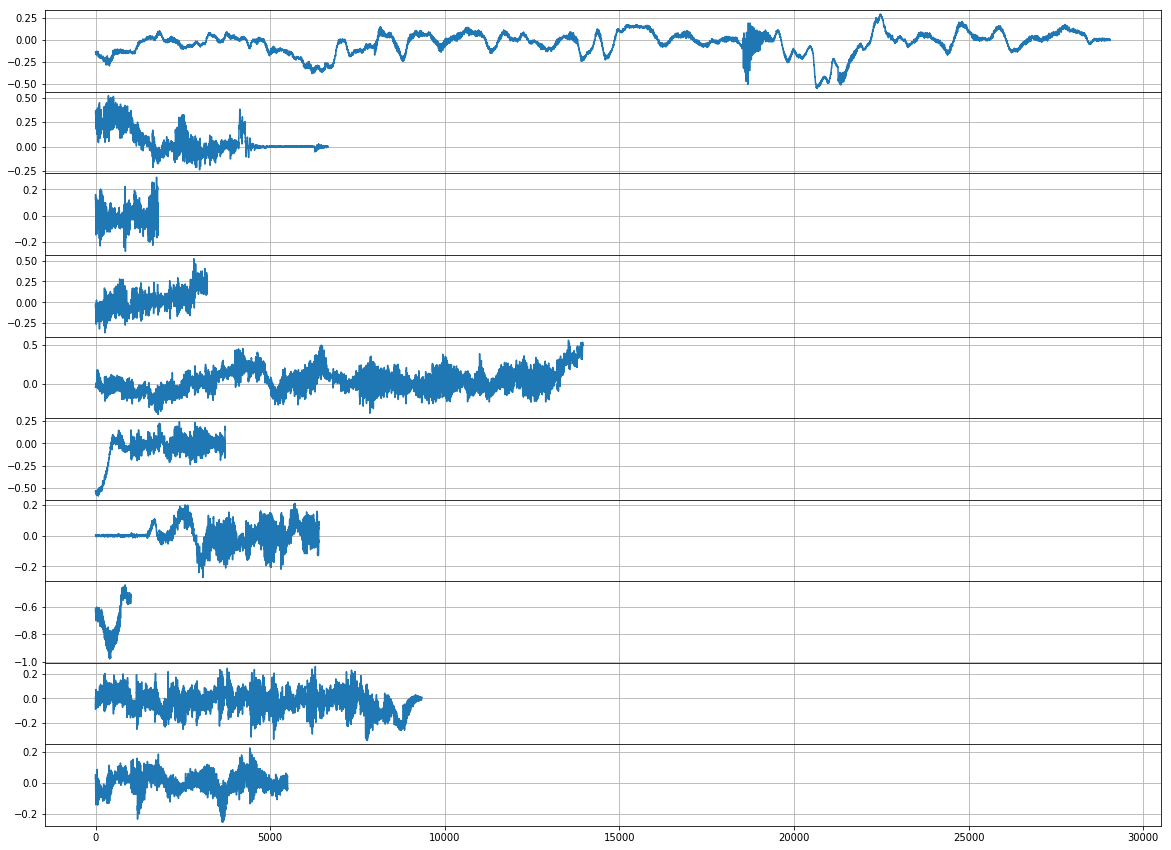

In [85]:
fig, axes = plt.subplots(10,1, sharex=True)
fig.set_size_inches(20,15)
fig.subplots_adjust(hspace=0)

k=0

for i in range(10):
    axes[i].plot(all_data[all_runs[i+10*k]][:,:,6].reshape(-1))
    axes[i].grid(True)

In [150]:
tr_list.loc[[19, 24, 55, 77, 128, 132, 138, 144], :]

,num_tr,num_te,surface
19,35,23,1
24,55,12,1
55,21,16,8
77,17,5,8
128,23,54,0
132,4,110,0
138,0,11,-1
144,23,3,8


In [ ]:
55, 77, 132[55:], 138[1:], 144[3:]

In [ ]:
[19, 24, 55, 77, 128, 132, 138, 144, ]

In [190]:
all_runs[144]

array([7233, 1990, 2141, 2742, 2749, 2152, 3239, 2024, 2447, 2404, 2132,
       2131, 3224, 2173, 2845, 2530, 2764, 3138, 3301, 1807, 2353, 2278,
       2544, 2170, 4177, 6274])

In [ ]:
all_runs[132][55]

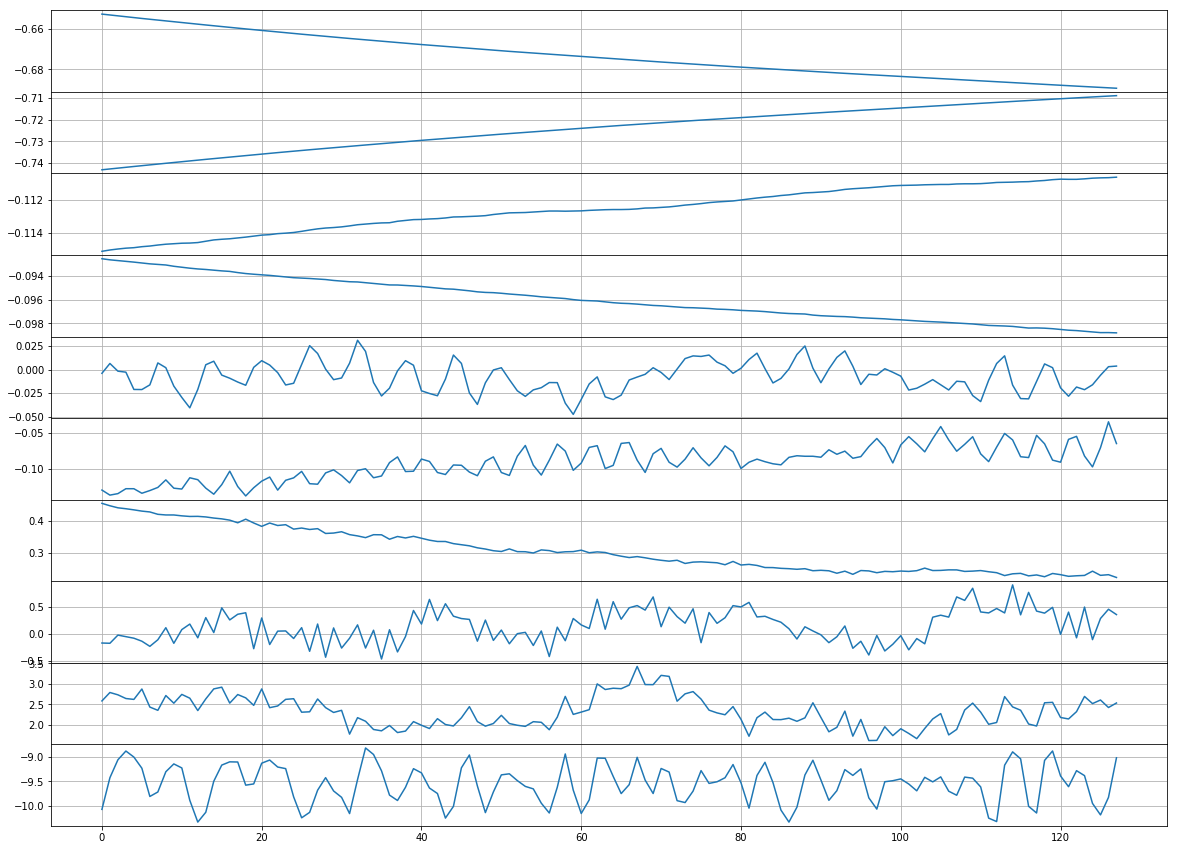

In [86]:
fig, axes = plt.subplots(10,1, sharex=True)
fig.set_size_inches(20,15)
fig.subplots_adjust(hspace=0)


for i in range(10):
    axes[i].plot(all_data[all_runs[144]][3,:,i].reshape(-1))
    axes[i].grid(True)

In [89]:
X_train[X_train['run_id']==0].head()

,series_id,run_id,run_pos,row_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
2432,19,0,0,19_0,0,0.82149,-0.55018,-0.078026,0.12790,-0.037375,0.061497,-0.13716,0.024075,3.8925,-9.0722
2433,19,0,0,19_1,1,0.82160,-0.55002,-0.078009,0.12793,-0.014339,0.049700,-0.14883,0.244750,3.8680,-9.2391
2434,19,0,0,19_2,2,0.82170,-0.54987,-0.077994,0.12794,0.002952,0.034608,-0.14425,0.202730,3.9080,-9.0733
2435,19,0,0,19_3,3,0.82181,-0.54968,-0.078020,0.12800,-0.005160,0.040884,-0.15265,-0.056117,4.0634,-8.8846
2436,19,0,0,19_4,4,0.82192,-0.54951,-0.078001,0.12804,-0.017418,0.054860,-0.15416,0.281510,4.0076,-9.1801


In [92]:
len(train_runs)

79

In [94]:
from scipy import signal

In [95]:
cols = ['linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z', 'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z']
df_peak = pd.DataFrame()

for i in tqdm(range(len(train_runs))):
    X_tr = X_train[X_train['run_id']==i]
    df_cols = pd.DataFrame()
    for col in cols:
        peaks = signal.find_peaks(X_tr[col], rel_height=1.0)[0]
        peak_num = len(peaks)
        peak_width = signal.peak_widths(X_tr[col], peaks, rel_height=1.0)[0]
        peak_pro = signal.peak_prominences(X_tr[col], peaks)[0]
        
        if peak_num != 0:
            peak_df = pd.DataFrame({
                             col+'_peak_num':[peak_num], 
                             col+'_peak_width_max':[np.max(peak_width)],
                             col+'_peak_width_min':[np.min(peak_width)],
                             col+'_peak_width_mean':[np.mean(peak_width)],
                             col+'_peak_pro_max':[np.max(peak_pro)],
                             col+'_peak_pro_min':[np.min(peak_pro)],
                             col+'_peak_pro_mean':[np.mean(peak_pro)]
                            }, index=[i//128])
        else:
            peak_df = pd.DataFrame({
                             col+'_peak_num':[peak_num], 
                             col+'_peak_width_max':[0],
                             col+'_peak_width_min':[0],
                             col+'_peak_width_mean':[0],
                             col+'_peak_pro_max':[0],
                             col+'_peak_pro_min':[0],
                             col+'_peak_pro_mean':[0]
                            }, index=[i//128])
            
        df_cols = pd.concat([df_cols, peak_df], axis=1)
    df_peak = pd.concat([df_peak, df_cols], axis=0)

100%|██████████| 80/80 [00:01<00:00, 44.09it/s]


In [97]:
df_peak.head()

,linear_acceleration_X_peak_num,linear_acceleration_X_peak_width_max,linear_acceleration_X_peak_width_min,linear_acceleration_X_peak_width_mean,linear_acceleration_X_peak_pro_max,linear_acceleration_X_peak_pro_min,linear_acceleration_X_peak_pro_mean,linear_acceleration_Y_peak_num,linear_acceleration_Y_peak_width_max,linear_acceleration_Y_peak_width_min,...,angular_velocity_Y_peak_pro_max,angular_velocity_Y_peak_pro_min,angular_velocity_Y_peak_pro_mean,angular_velocity_Z_peak_num,angular_velocity_Z_peak_width_max,angular_velocity_Z_peak_width_min,angular_velocity_Z_peak_width_mean,angular_velocity_Z_peak_pro_max,angular_velocity_Z_peak_pro_min,angular_velocity_Z_peak_pro_mean
0,4695,5906.527227,1.000401,13.728843,3.4489,0.000050,0.270615,3353,7121.413816,1.001508,...,0.179290,1.000000e-06,0.012606,3164,5559.331992,1.000991,12.731189,0.394497,0.000003,0.008877
0,2388,2509.829710,1.000196,15.069955,23.4150,0.000002,1.589139,1731,1644.077763,1.001969,...,0.713000,1.500000e-06,0.058993,1836,1889.939560,1.000319,16.056154,0.538820,0.000001,0.029432
0,3220,3270.836026,1.001772,14.217553,27.5520,0.004910,2.946488,2277,3827.950486,1.000620,...,0.794560,3.600000e-05,0.100931,2456,4083.913950,1.000258,19.402828,0.665180,0.000010,0.050308
0,834,762.969670,1.000381,10.916098,16.1635,0.000480,1.872622,615,601.784015,1.007873,...,0.458750,1.906000e-04,0.081438,481,781.678546,1.000566,12.678992,0.366700,0.000020,0.051252
0,628,536.235431,1.000887,8.406553,2.3663,0.000380,0.245804,398,564.627464,1.001915,...,0.131762,1.300000e-05,0.012123,486,438.511933,1.014970,6.262517,0.101090,0.000050,0.005975


In [32]:
np.where(np.asarray([ len(np.unique(train_y[run])) for run in train_runs ])==2)

(array([ 7, 52, 59, 71]),)

In [58]:
train_y[train_runs[7]]

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8])

In [33]:
flat_list = [series_id for run in all_runs for series_id in run]
print(len(flat_list), len(np.unique(flat_list)))

7600 7600


In [34]:
len(train_X)

3810

In [35]:
len(test_X)

3816

In [30]:
lost_run = lost_run + 3810

In [31]:
all_runs.append(lost_run)

In [32]:
tr_list = [] 
for i in range(len(all_runs)):
    tr_list.append(np.array([np.sum(all_runs[i]<3810), np.sum(all_runs[i]>=3810)]))

In [33]:
tr_y_list = []
for i in range(len(all_runs)):
    if len(all_runs[i][all_runs[i]<3810])>0:
        tr_y_list.append(train_y[all_runs[i][all_runs[i]<3810][0]])
    else:
        tr_y_list.append(-1)

In [34]:
tr_list = pd.DataFrame(tr_list, columns=['num_tr', 'num_te'])
tr_list = pd.concat([tr_list, pd.DataFrame(tr_y_list, columns=['surface'])], axis=1)

In [35]:
tr_list

,num_tr,num_te,surface
0,101,126,2
1,52,0,8
2,14,0,1
3,25,0,8
4,53,56,8
5,11,18,1
6,50,0,5
7,8,0,1
8,16,57,1
9,7,36,5


In [39]:
len_list = []
for i in range(len(all_runs)):
    len_list.append(len(all_runs[i]))

In [40]:
len_list

[227,
 52,
 14,
 25,
 109,
 29,
 50,
 8,
 73,
 43,
 57,
 216,
 21,
 82,
 27,
 54,
 188,
 7,
 177,
 58,
 43,
 93,
 139,
 7,
 67,
 30,
 66,
 61,
 101,
 153,
 10,
 301,
 9,
 35,
 3,
 8,
 216,
 2,
 19,
 12,
 22,
 32,
 28,
 73,
 20,
 17,
 40,
 108,
 9,
 1,
 61,
 18,
 23,
 20,
 16,
 37,
 39,
 3,
 18,
 27,
 3,
 33,
 27,
 63,
 64,
 38,
 5,
 1,
 46,
 12,
 28,
 4,
 133,
 36,
 28,
 124,
 87,
 22,
 27,
 133,
 52,
 7,
 8,
 35,
 130,
 24,
 54,
 198,
 76,
 30,
 85,
 1,
 20,
 23,
 32,
 1,
 146,
 32,
 4,
 87,
 1,
 191,
 9,
 20,
 27,
 26,
 5,
 77,
 235,
 1,
 26,
 18,
 2,
 3,
 7,
 2,
 30,
 12,
 129,
 141,
 1,
 3,
 1,
 1,
 6,
 26,
 10,
 67,
 77,
 13,
 1,
 30,
 114,
 5,
 46,
 30,
 151,
 1,
 11,
 54,
 41,
 41,
 19,
 39,
 26,
 100,
 23,
 79,
 150,
 5,
 4,
 26]

In [42]:
tr_list = pd.concat([tr_list, pd.DataFrame(len_list, columns=['len'])], axis=1)

In [45]:
tr_list['tr_rate'] = tr_list['num_tr']/tr_list['len']
tr_list['te_rate'] = tr_list['num_te']/tr_list['len']

In [43]:
tr_list.groupby('surface')['len'].mean()

surface
-1     24.166667
 0     75.142857
 1     52.250000
 2    188.000000
 3     53.300000
 4    114.200000
 5     64.454545
 6     99.142857
 7    129.000000
 8     29.516129
Name: len, dtype: float64

In [46]:
tr_list.groupby('surface')['tr_rate'].mean()

surface
-1    0.000000
 0    0.677268
 1    0.699893
 2    0.536873
 3    0.860230
 4    0.803000
 5    0.629713
 6    0.499346
 7    0.162791
 8    0.783766
Name: tr_rate, dtype: float64

In [47]:
tr_list.groupby('surface')['te_rate'].mean()

surface
-1    1.000000
 0    0.322732
 1    0.300107
 2    0.463127
 3    0.139770
 4    0.197000
 5    0.370287
 6    0.500654
 7    0.837209
 8    0.216234
Name: te_rate, dtype: float64

In [42]:
all_runs[0][all_runs[0]>=3810]-3810

array([2659,  812, 3008,  958, 1646, 1576, 3227, 3368, 3231, 2836, 2081,
       2125, 2538, 1561,  882, 3250, 3729, 2086, 2321, 1811, 1808,  750,
       2792, 1572, 2352, 2794, 2776,  720,  140, 2576,  395, 2250, 3084,
       2297,  467, 1845, 3235, 1603, 2053, 1080, 3225,  764, 1533, 1719,
        105, 1307, 3549, 3568, 3151, 3565,  704, 2370, 1024, 1517,   98,
       2965,  418, 1816, 3057, 2191, 2699, 2171,  818,  150, 2391, 1820,
        508, 1916, 2355, 1069, 1428,  698,  471, 2883, 3728, 1776, 2744,
       1932, 1799, 2795, 2114, 3080, 3440, 2057,  644, 2115,  298, 1079,
       3635, 2173, 3774, 1270, 1315, 1440, 1785, 1893, 2479, 3326, 3113,
         92, 1614, 3706, 2722,  468, 2144, 2003, 1857,  606, 2345, 3588,
       2896,   17, 1460, 1262, 1417, 3076, 2201, 2578,  710,  537,  907,
        265, 3554,  284, 1495, 3397])

In [48]:
tr_list

,num_tr,num_te,surface,len,tr_rate,te_rate
0,101,126,2,227,0.444934,0.555066
1,52,0,8,52,1.000000,0.000000
2,14,0,1,14,1.000000,0.000000
3,25,0,8,25,1.000000,0.000000
4,53,56,8,109,0.486239,0.513761
5,11,18,1,29,0.379310,0.620690
6,50,0,5,50,1.000000,0.000000
7,8,0,1,8,1.000000,0.000000
8,16,57,1,73,0.219178,0.780822
9,7,36,5,43,0.162791,0.837209


In [51]:
train_run_id = tr_list[tr_list['surface']!=-1].index
test_run_id = tr_list[tr_list['surface']==-1].index

X_train = tr_list[tr_list['surface']!=-1]
X_test = tr_list[tr_list['surface']==-1]
y_train = X_train['surface'].values
X_train.drop(['surface'], axis=1, inplace=True)
X_test.drop(['surface'], axis=1, inplace=True)

In [50]:
y_id = tr_list[tr_list['surface']!=-1]['surface'].values

In [78]:
X_test['series_id'] = X_test['series_id'] + 3810
data_all = pd.concat([X_train, X_test], axis=0)

In [72]:
data_all.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [73]:
all_series_df = pd.DataFrame()
for run_id in range(len(all_runs)):
    series_df = pd.DataFrame()
    for run_pos in range(len(all_runs[run_id])):
        series_id = all_runs[run_id][run_pos]
        series_id_df = pd.DataFrame({'series_id':[series_id], 'run_id':[run_id], 'run_pos':[run_pos]})
        series_df = pd.concat([series_df, series_id_df], axis=0)
    all_series_df = pd.concat([all_series_df, series_df], axis=0)

In [74]:
all_series_df.head()

,series_id,run_id,run_pos
0,19,0,0
0,757,0,1
0,1680,0,2
0,452,0,3
0,504,0,4


In [79]:
data_all = all_series_df.merge(data_all, how='left', on='series_id')

In [80]:
data_all.head()

,series_id,run_id,run_pos,row_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,19,0,0,19_0,0,0.82149,-0.55018,-0.078026,0.12790,-0.037375,0.061497,-0.13716,0.024075,3.8925,-9.0722
1,19,0,0,19_1,1,0.82160,-0.55002,-0.078009,0.12793,-0.014339,0.049700,-0.14883,0.244750,3.8680,-9.2391
2,19,0,0,19_2,2,0.82170,-0.54987,-0.077994,0.12794,0.002952,0.034608,-0.14425,0.202730,3.9080,-9.0733
3,19,0,0,19_3,3,0.82181,-0.54968,-0.078020,0.12800,-0.005160,0.040884,-0.15265,-0.056117,4.0634,-8.8846
4,19,0,0,19_4,4,0.82192,-0.54951,-0.078001,0.12804,-0.017418,0.054860,-0.15416,0.281510,4.0076,-9.1801


In [81]:
X_train = pd.DataFrame()
for i in range(len(train_run_id)):
    X_train = pd.concat([X_train, data_all[data_all['run_id']==train_run_id[i]]], axis=0)

In [82]:
X_test = pd.DataFrame()
for i in range(len(test_run_id)):
    X_test = pd.concat([X_test, data_all[data_all['run_id']==test_run_id[i]]], axis=0)

In [83]:
X_test.head()

,series_id,run_id,run_pos,row_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
548480,3855,79,0,45_0,0,0.38258,0.91111,0.14362,0.053602,0.000541,0.001189,-0.000717,0.131950,2.8930,-9.4292
548481,3855,79,0,45_1,1,0.38259,0.91111,0.14361,0.053600,0.005452,-0.001450,0.003537,0.118330,2.9383,-9.3934
548482,3855,79,0,45_2,2,0.38248,0.91116,0.14362,0.053603,-0.000739,-0.002407,0.000055,0.064610,2.9548,-9.3039
548483,3855,79,0,45_3,3,0.38249,0.91116,0.14362,0.053605,-0.002587,-0.000776,0.001685,0.091434,2.9415,-9.2856
548484,3855,79,0,45_4,4,0.38248,0.91115,0.14363,0.053608,-0.007552,0.000766,-0.001396,0.082298,2.9028,-9.3292


In [85]:
np.fft.fft(X_train['angular_velocity_X'])

(827648,)

In [89]:
def feat_eng(df):
    data = pd.DataFrame()

    df['total_acce'] = (df['linear_acceleration_X']**2 + df['linear_acceleration_Y']**2 + df['linear_acceleration_Z']**2)**0.5
    df['fft_angvel_X'] = np.fft.fft(df['angular_velocity_X']).real
    df['fft_angvel_Y'] = np.fft.fft(df['angular_velocity_Y']).real
    df['fft_angvel_Z'] = np.fft.fft(df['angular_velocity_Z']).real
    df['fft_linacc_X'] = np.fft.fft(df['linear_acceleration_X']).real
    df['fft_linacc_Y'] = np.fft.fft(df['linear_acceleration_Y']).real
    df['fft_linacc_Z'] = np.fft.fft(df['linear_acceleration_Z']).real
    
    
    df_columns = [#'orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W',
                  'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z',
                  'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z',
                  'total_acce']
    
    for col in tqdm(df.columns[9:]):
        data[col + '_mean'] = df.groupby(['run_id'])[col].mean()
        data[col + '_median'] = df.groupby(['run_id'])[col].median()
        data[col + '_max'] = df.groupby(['run_id'])[col].max()
        data[col + '_min'] = df.groupby(['run_id'])[col].min()
        data[col + '_std'] = df.groupby(['run_id'])[col].std()
        data[col + '_range'] = data[col + '_max'] - data[col + '_min']
        data[col + '_maxtoMin'] = data[col + '_max'] / data[col + '_min']
        data[col + '_mean_abs_chg'] = df.groupby(['run_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        #data[col + '_mean_change_of_abs_change'] = df.groupby('series_id')[col].apply(mean_change_of_abs_change)
        data[col + '_abs_max'] = df.groupby(['run_id'])[col].apply(lambda x: np.max(np.abs(x)))
        data[col + '_abs_min'] = df.groupby(['run_id'])[col].apply(lambda x: np.min(np.abs(x)))
        data[col + '_abs_avg'] = (data[col + '_abs_min'] + data[col + '_abs_max'])/2
        
        
    #data['corr_linZangX'] = np.correlate(np.abs(tmp_df[:, 0]), np.abs(tmp_df[:, 1]))
    return data

In [87]:
from tqdm import tqdm

In [90]:
X_train = feat_eng(X_train)
X_test = feat_eng(X_test)

100%|██████████| 13/13 [00:00<00:00, 14.80it/s]


In [71]:
X_train.head()

,run_id,run_pos,angular_velocity_X_mean,angular_velocity_X_median,angular_velocity_X_max,angular_velocity_X_min,angular_velocity_X_std,angular_velocity_X_range,angular_velocity_X_maxtoMin,angular_velocity_X_mean_abs_chg,...,fft_linacc_Z_median,fft_linacc_Z_max,fft_linacc_Z_min,fft_linacc_Z_std,fft_linacc_Z_range,fft_linacc_Z_maxtoMin,fft_linacc_Z_mean_abs_chg,fft_linacc_Z_abs_max,fft_linacc_Z_abs_min,fft_linacc_Z_abs_avg
0,0,0,0.004258,0.006248,0.045317,-0.037375,0.017182,0.082692,-1.212495,0.010105,...,-5.254429,1140.668385,-1026.095757,396.894489,2166.764142,-1.111659,431.432734,1140.668385,0.988755,570.828570
1,0,1,0.006034,0.008310,0.039981,-0.029594,0.014501,0.069575,-1.350983,0.007493,...,-267.252157,8216.703360,-9783.766435,3023.084440,18000.469795,-0.839830,3572.832812,9783.766435,34.045162,4908.905798
2,0,2,-0.003544,-0.004574,0.042608,-0.057590,0.022977,0.100198,-0.739851,0.010263,...,-117.533229,1100.155481,-965.961517,399.175595,2066.116998,-1.138923,435.136022,1100.155481,3.555499,551.855490
3,0,3,-0.007599,-0.004991,0.048760,-0.061733,0.026261,0.110493,-0.789853,0.008006,...,378.150820,2974.965438,-2996.721293,1258.806722,5971.686731,-0.992740,1307.498601,2996.721293,7.614732,1502.168013
4,0,4,-0.004911,-0.009461,0.057361,-0.035192,0.018416,0.092553,-1.629944,0.007253,...,-165.001940,3614.007013,-3409.687449,1195.059380,7023.694463,-1.059923,1308.594640,3614.007013,33.785158,1823.896086


In [58]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import accuracy_score

In [74]:
val_idx = X_train[X_train['run_id']>50].index
train_idx = X_train[X_train['run_id']<=50].index
X_train.drop('series_id', axis=1, inplace=True)

KeyError: "labels ['series_id'] not contained in axis"

In [98]:
y_id.shape

(80,)

In [63]:
df_train_y['surface'] = df_train_y['surface'].replace(surface_to_numeric).values
y_id = df_train_y.groupby('run_id')['surface'].mean().astype(int)

In [99]:
N_SPLITS = 4
class_num = 9

splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(df_peak, y_id))

clf = []
val_acc = []
val_pred = pd.DataFrame()

lgb_params = {
               'feature_fraction': 0.9,
               'metric': 'multi_logloss',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'multiclass',
               'num_class': class_num,
               'num_leaves': 2**5,
               'verbose':0, 
               'seed':123
              }

for train_idx, val_idx in splits:
    X_tr, y_tr = df_peak.iloc[train_idx, :], y_id[train_idx]
    X_val, y_val = df_peak.iloc[val_idx, :], y_id[val_idx]

    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=130)
    pred_lgb = model_lgb.predict(X_val)

    val_acc.append(accuracy_score(y_val, np.argmax(pred_lgb, axis=1)))

clf.append(model_lgb)

/home/cwademo123/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


[1]	valid_0's multi_logloss: 2.04821
Training until validation scores don't improve for 130 rounds.
[2]	valid_0's multi_logloss: 2.03155
[3]	valid_0's multi_logloss: 2.02682
[4]	valid_0's multi_logloss: 2.02642
[5]	valid_0's multi_logloss: 2.02505
[6]	valid_0's multi_logloss: 2.02911
[7]	valid_0's multi_logloss: 2.01914
[8]	valid_0's multi_logloss: 2.02797
[9]	valid_0's multi_logloss: 2.01619
[10]	valid_0's multi_logloss: 2.027
[11]	valid_0's multi_logloss: 2.02382
[12]	valid_0's multi_logloss: 2.02806
[13]	valid_0's multi_logloss: 2.03651
[14]	valid_0's multi_logloss: 2.04081
[15]	valid_0's multi_logloss: 2.04529
[16]	valid_0's multi_logloss: 2.0554
[17]	valid_0's multi_logloss: 2.06331
[18]	valid_0's multi_logloss: 2.05925
[19]	valid_0's multi_logloss: 2.06136
[20]	valid_0's multi_logloss: 2.07563
[21]	valid_0's multi_logloss: 2.0824
[22]	valid_0's multi_logloss: 2.09116
[23]	valid_0's multi_logloss: 2.09244
[24]	valid_0's multi_logloss: 2.09376
[25]	valid_0's multi_logloss: 2.10853


[141]	valid_0's multi_logloss: 2.24287
[142]	valid_0's multi_logloss: 2.24672
[143]	valid_0's multi_logloss: 2.25081
[144]	valid_0's multi_logloss: 2.24548
[145]	valid_0's multi_logloss: 2.25398
[146]	valid_0's multi_logloss: 2.26267
[147]	valid_0's multi_logloss: 2.26971
[148]	valid_0's multi_logloss: 2.27652
[149]	valid_0's multi_logloss: 2.28019
[150]	valid_0's multi_logloss: 2.28157
[151]	valid_0's multi_logloss: 2.28928
[152]	valid_0's multi_logloss: 2.29578
[153]	valid_0's multi_logloss: 2.30017
[154]	valid_0's multi_logloss: 2.30825
[155]	valid_0's multi_logloss: 2.31149
[156]	valid_0's multi_logloss: 2.31316
[157]	valid_0's multi_logloss: 2.31733
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 1.81507
[1]	valid_0's multi_logloss: 1.94297
Training until validation scores don't improve for 130 rounds.
[2]	valid_0's multi_logloss: 1.92165
[3]	valid_0's multi_logloss: 1.88857
[4]	valid_0's multi_logloss: 1.86934
[5]	valid_0's multi_logloss: 1.85374
[6]	valid_0's mu

[42]	valid_0's multi_logloss: 3.5692
[43]	valid_0's multi_logloss: 3.57808
[44]	valid_0's multi_logloss: 3.57001
[45]	valid_0's multi_logloss: 3.57813
[46]	valid_0's multi_logloss: 3.58836
[47]	valid_0's multi_logloss: 3.58711
[48]	valid_0's multi_logloss: 3.60138
[49]	valid_0's multi_logloss: 3.5944
[50]	valid_0's multi_logloss: 3.61028
[51]	valid_0's multi_logloss: 3.60443
[52]	valid_0's multi_logloss: 3.60763
[53]	valid_0's multi_logloss: 3.61206
[54]	valid_0's multi_logloss: 3.61713
[55]	valid_0's multi_logloss: 3.61354
[56]	valid_0's multi_logloss: 3.6242
[57]	valid_0's multi_logloss: 3.62892
[58]	valid_0's multi_logloss: 3.63501
[59]	valid_0's multi_logloss: 3.63786
[60]	valid_0's multi_logloss: 3.63518
[61]	valid_0's multi_logloss: 3.64352
[62]	valid_0's multi_logloss: 3.64816
[63]	valid_0's multi_logloss: 3.65118
[64]	valid_0's multi_logloss: 3.65786
[65]	valid_0's multi_logloss: 3.66138
[66]	valid_0's multi_logloss: 3.66009
[67]	valid_0's multi_logloss: 3.66818
[68]	valid_0's 

In [100]:
val_acc

[0.2608695652173913, 0.4, 0.3684210526315789, 0.3333333333333333]

In [68]:
feature_imp = np.zeros(X_train.shape[1])
for model in clf:
    feature_imp+=model.feature_importance(importance_type='gain')

pd.DataFrame(feature_imp, index=X_train.columns).sort_values(by=0, ascending=False)

,0
orientation_W_mean_abs_chg,144.096979
orientation_Z_mean_abs_chg,110.039153
orientation_Y_mean_abs_chg,81.067789
orientation_W_max,49.955264
orientation_Z_abs_max,44.078464
orientation_Y_range,35.211758
orientation_W_abs_max,23.620795
orientation_W_median,19.695049
orientation_W_maxtoMin,16.924190
orientation_W_range,16.523008


In [119]:
preds_test = []

for model in clf:
    preds_test.append(model.predict(X_test))
    
preds_test = np.argmax(np.mean(preds_test, axis=0), axis=1)

In [122]:
test_run_id

Int64Index([ 79,  80,  81,  85,  91,  92,  93,  94,  95,  98, 100, 102, 103,
            104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117,
            119, 120, 121, 122, 123, 124, 125, 126, 127, 130, 133, 134, 135,
            137, 138, 139, 142, 143, 145, 149, 150, 151],
           dtype='int64')

In [123]:
tr_list.loc[test_run_id, 'surface'] = preds_test

In [124]:
tr_list

,num_tr,num_te,surface
0,101,126,2
1,52,0,8
2,14,0,1
3,25,0,8
4,53,56,8
5,11,18,1
6,50,0,5
7,8,0,1
8,16,57,1
9,7,36,5


In [57]:
(all_data[all_runs[0]]).reshape(-1, 10)

array([[ 0.82149 , -0.55018 , -0.078026, ...,  0.024075,  3.8925  ,
        -9.0722  ],
       [ 0.8216  , -0.55002 , -0.078009, ...,  0.24475 ,  3.868   ,
        -9.2391  ],
       [ 0.8217  , -0.54987 , -0.077994, ...,  0.20273 ,  3.908   ,
        -9.0733  ],
       ...,
       [ 0.55228 ,  0.82014 ,  0.12734 , ...,  0.15704 ,  2.9305  ,
        -9.3658  ],
       [ 0.55227 ,  0.82014 ,  0.12734 , ...,  0.15173 ,  2.9292  ,
        -9.375   ],
       [ 0.55224 ,  0.82016 ,  0.12734 , ...,  0.17038 ,  2.9321  ,
        -9.3881  ]])

In [51]:
np.mean(all_data[all_runs[0]], axis=0).shape

(128, 10)

In [125]:
submission = pd.read_csv('../input/sample_submission.csv')

In [126]:
for i in range(len(all_runs)):
    if tr_list.loc[i, 'num_te'] > 0:
        submission.loc[all_runs[i][all_runs[i]>=3810]-3810, 'surface'] = tr_list.loc[i, 'surface']

In [127]:
submission

,series_id,surface
0,0,5
1,1,1
2,2,1
3,3,6
4,4,2
5,5,1
6,6,4
7,7,5
8,8,8
9,9,5


In [144]:
submission.head()

,series_id,surface
0,0,5
1,1,1
2,2,0
3,3,6
4,4,2


In [128]:
numeric_to_surface = dict(zip(range(num_surfaces), surface_names))
print('Convert to surface: ', numeric_to_surface)

submission['surface'] = submission['surface'].replace(numeric_to_surface).values

Convert to surface:  {0: 'fine_concrete', 1: 'concrete', 2: 'soft_tiles', 3: 'tiled', 4: 'soft_pvc', 5: 'hard_tiles_large_space', 6: 'carpet', 7: 'hard_tiles', 8: 'wood'}


In [129]:
submission.to_csv('../output/submission_11.csv', index=False)
submission.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,concrete
3,3,carpet
4,4,soft_tiles
